# Purpose
This notebook's purpose is to produce the model checking plots of the MIXLB model that will be needed in the 3rd version of the paper for ArXiv.

# Notebook parameters

In [1]:
# Declare paths to where data is or should be stored
DATA_PATH =\
    "../../data/processed/model_ready_car_data.csv"

PARAM_PATH =\
    "../../models/estimated_mixlb_parameters.csv"

HESSIAN_PATH =\
    "../../models/estimated_mixlb_hessian.csv"

POSTERIOR_PROB_PATH =\
    "../../models/posterior_probs_mixlb.csv"

FIGURE_DIR =\
    "../../reports/figures/mixlb"

# Note needed column names
ALT_ID_COLUMN = 'alt_id'
OBS_ID_COLUMN = 'obs_id'
CHOICE_COLUMN = 'choice'
BODY_COLUMN = 'body_type'
FUEL_COLUMN = 'fuel_type'

# Note the number of samples being drawn for the model checking
NUM_SAMPLES = 200
# Note the number of draws being used for Monte Carlo integration
# in the probability function
NUM_MIXING_DRAWS = 250
# Note the seed for generating the random variate draws for
# Monte Carlo integration in the probability function. Ensures
# we use the same random variate draws used to estimate the model
# and hessian.
MIXL_DRAW_SEED = 601

# Random seed for reproducibility of model checking
SEED = 1131

# Import modules

In [2]:
# Built-in modules
import sys
import time
import pathlib
from collections import OrderedDict

# Third-party modules
import torch
import numpy as np
import pandas as pd
import pylogit as pl
import pylogit.mixed_logit_calcs as mlc
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm

# Local modules
sys.path.insert(0, '../../')
import src.models.mixlb as mixlb
import src.models.torch_utils as utils
import src.viz as viz

# Load needed data

In [3]:
car_df = pd.read_csv(DATA_PATH)
estimated_params =\
    np.loadtxt(PARAM_PATH, delimiter=',', skiprows=1)
estimated_hessian = np.loadtxt(HESSIAN_PATH, delimiter=',')

# Get the observation_ids
observation_ids = car_df[OBS_ID_COLUMN].values

# Load pytorch model and needed objects

In [4]:
# Instantiate the model
mixl_model = mixlb.MIXLB()

In [5]:
####
# Create the various input objects needed for mixlb model.
# These should be packaged together and stored as a class
# Should be as simple as InputMixlB.from_df(car_df)
####
# Create specification and name dictionaries
mnl_spec, mnl_names = OrderedDict(), OrderedDict()

for col, display_name in mixlb.DESIGN_TO_DISPLAY_DICT.items():
    mnl_spec[col] = 'all_same'
    mnl_names[col] = display_name

# Instantiate a MNL with the same design matrix as the MIXL.
mnl_model =\
    pl.create_choice_model(data=car_df,
                           alt_id_col=ALT_ID_COLUMN,
                           obs_id_col=OBS_ID_COLUMN,
                           choice_col=CHOICE_COLUMN,
                           specification=mnl_spec,
                           model_type='MNL',
                           names=mnl_names)

# Create target variables for the loss function
torch_choices =\
    torch.from_numpy(mnl_model.choices.astype(np.float32)).double()

# Get the design matrix from the original and forecast data
orig_design_matrix_np = mnl_model.design
orig_design_matrix =\
    torch.tensor(orig_design_matrix_np.astype(np.float32))

# Get the rows_to_obs and rows_to_mixers matrices.
rows_to_obs =\
    utils.create_sparse_mapping_torch(observation_ids)
rows_to_mixers =\
    utils.create_sparse_mapping_torch(observation_ids)

####
# Get the normal random variates.
####
# Determine the number of draws being used for the mixed logit
num_draws = NUM_MIXING_DRAWS
# Determine the number of observations with randomly distributed
# sensitivities
num_mixers = car_df.obs_id.unique().size

# Get the random draws needed for the draws of each coeffcient
# Each element in the list will be a 2D ndarray of shape
# num_mixers by num_draws
normal_rvs_list_np =\
    mlc.get_normal_draws(num_mixers,
                         num_draws,
                         mixl_model.design_info.num_mixing_vars,
                         seed=MIXL_DRAW_SEED)
normal_rvs_list = [torch.from_numpy(x).double() for x in normal_rvs_list_np]


/Users/timothyb0912/minimamba/envs/checkYourself/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


# Create sampling distribution

In [6]:
# Extract the portion of the hessian pertaining to estimated
# parameters, excluding rows and columns for the fixed parameters
desired_rows =\
    np.concatenate((np.arange(0, 21), np.arange(23, 27)), axis=0)
hessian_core =\
    estimated_hessian[np.ix_(desired_rows, desired_rows)]

In [7]:
# Note we don't multiply by -1 because this is the hessian
# of the log-loss as opposed to the log-likelihood. The
# -1 is already included in the log-loss definition.
asymptotic_cov = np.linalg.inv(hessian_core)

In [8]:
asymptotic_sampling_dist =\
    multivariate_normal(mean=estimated_params[desired_rows],
                        cov=asymptotic_cov)

# Sample $\left( y, \theta \right)$ from posterior distribution

In [9]:
# Set a random seed for reproducibility
np.random.seed(SEED)

# Sample the estimated parameters
posterior_samples_estimated =\
    asymptotic_sampling_dist.rvs(size=(NUM_SAMPLES,))

# Get a complete array of posterior samples, including the
# parameters fixed to zero
posterior_samples =\
    np.concatenate((posterior_samples_estimated[:, np.arange(0, 21)],
                    np.zeros((NUM_SAMPLES, 2)),
                    posterior_samples_estimated[:, np.arange(21, 25)]),
                   axis=1)

In [10]:
# Initialize the tensor of posterior probabilities
posterior_probs_tensor =\
    torch.empty((mnl_model.design.shape[0], NUM_SAMPLES),
                dtype=torch.double)

# Compute the probabilities for each posterior sample of parameters
with torch.no_grad():
    for idx in tqdm(range(NUM_SAMPLES), total=NUM_SAMPLES):
        # Set model parameters
        mixl_model.set_params_numpy(posterior_samples[idx, :])
        # Compute probabilities and assign them to the array
        posterior_probs_tensor[:, idx] =\
            mixl_model(design_2d=orig_design_matrix,
                       rows_to_obs=rows_to_obs,
                       rows_to_mixers=rows_to_mixers,
                       normal_rvs_list=normal_rvs_list)


In [11]:
# Convert the tensor into a numpy array
posterior_probs_array = posterior_probs_tensor.numpy()

# Save the posterior probabilities
np.savetxt(POSTERIOR_PROB_PATH,
           posterior_probs_array,
           delimiter=",")

# Get the simulated choices based on the posterior probabilities
sim_choices =\
    viz.simulate_choice_vector(posterior_probs_array, observation_ids)

# Produce desired plots

In [18]:
# Create the directory for the model checking plots
pathlib.Path(FIGURE_DIR).mkdir(parents=True, exist_ok=True) 

## 1. Predictive performance plots

### 1a. Overall Log-likelihood plot

In [19]:
# Create the path to where the plot should be saved
overall_log_likelihood_path =\
    pathlib.Path(FIGURE_DIR) / 'overall_log_likelihood.jpg'

# Compute the observed log-likelihood
with torch.no_grad():
    # Set the estimated parameters
    mixl_model.set_params_numpy(estimated_params)
    # Compute the estimated probabilities
    estimated_probs =\
        mixl_model(design_2d=orig_design_matrix,
                   rows_to_obs=rows_to_obs,
                   rows_to_mixers=rows_to_mixers,
                   normal_rvs_list=normal_rvs_list)
    # Compute the observed log-likelihood
    obs_log_likelihood =\
        (-1 * utils.log_loss(estimated_probs, torch_choices)).item()

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


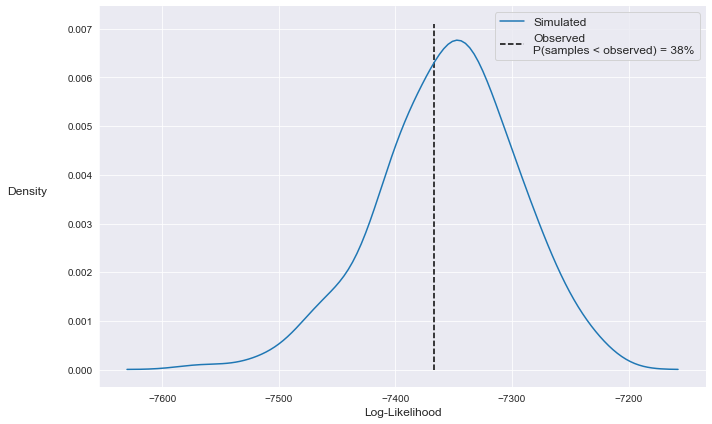

In [20]:
# Compute the simulated log-likelihood values
sim_log_likelihoods =\
    viz.compute_predictive_log_likelihoods(
        sim_choices, estimated_probs.numpy())

# Create the desired plot
viz.plot_continous_scalars(sim_log_likelihoods,
                           obs_log_likelihood,
                           output_file=overall_log_likelihood_path,
                          )
        

### 1b. Overall mean-square-error plot

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


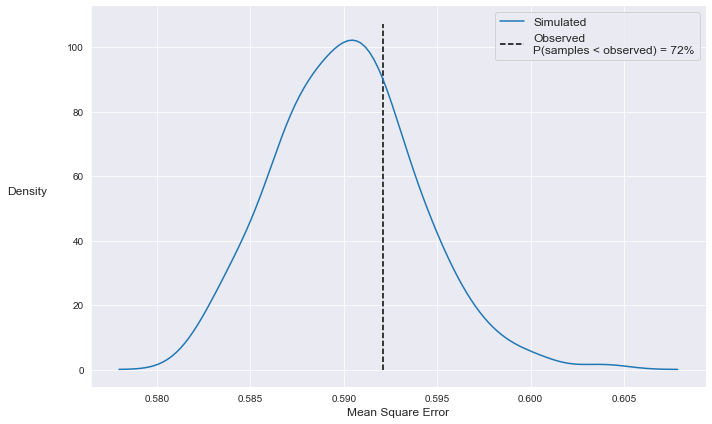

In [25]:
# Create the path to where the plot should be saved
overall_mse_path =\
    pathlib.Path(FIGURE_DIR) / 'overall_mean_square_error.jpg'

# Compute the observed mean-square-error values
obs_squared_errors = (mnl_model.choices - estimated_probs.numpy())**2
obs_mean_square_error =\
    obs_squared_errors[np.where(mnl_model.choices)].mean()

# Compute the simulated mean-square-errorvalues
sim_mean_square_error =\
    viz.compute_predictive_mse(
        sim_choices, estimated_probs.numpy())

# Create the desired plot
viz.plot_continous_scalars(sim_mean_square_error,
                           obs_mean_square_error,
                           x_label='Mean Square Error',
                           output_file=overall_mse_path,
                          )

### 1c. Log-likelihood plots by body and fuel type

In [27]:
# Get the available body and fuel types
body_types = car_df[BODY_COLUMN].unique()
fuel_types = car_df[FUEL_COLUMN].unique()

Automatic pdb calling has been turned ON


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using modul

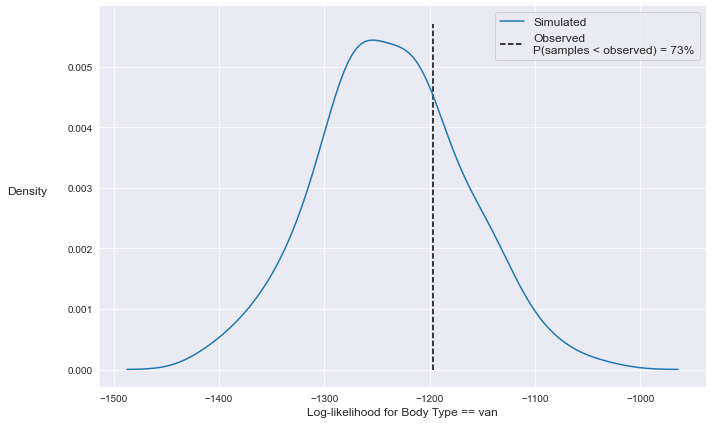

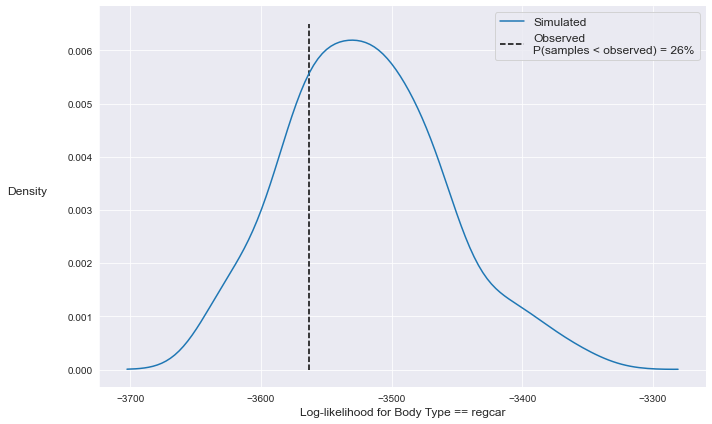

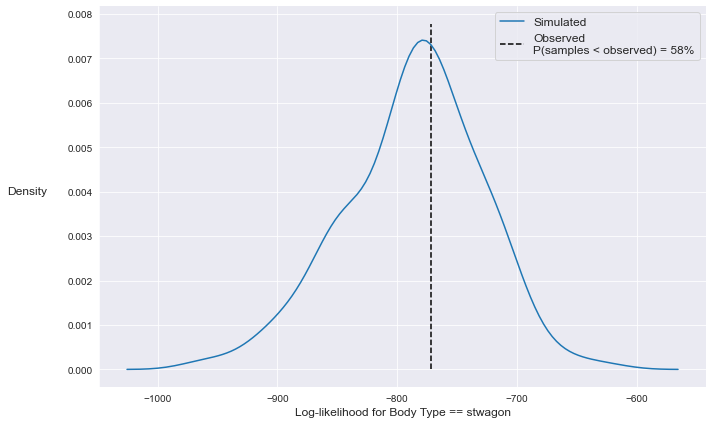

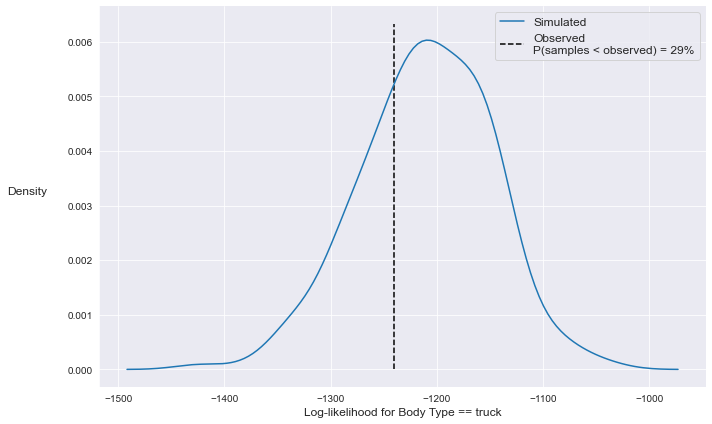

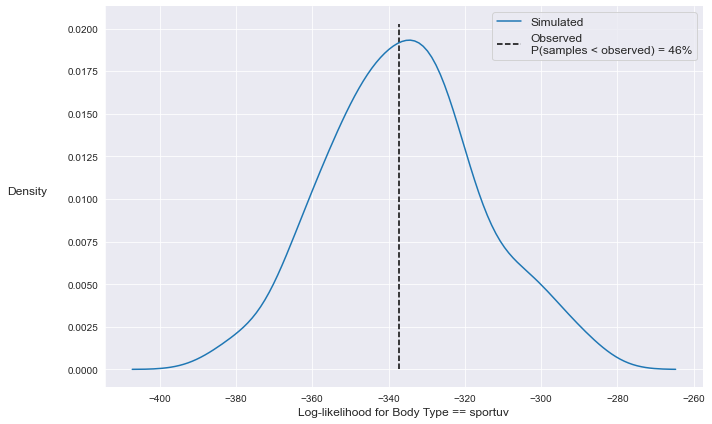

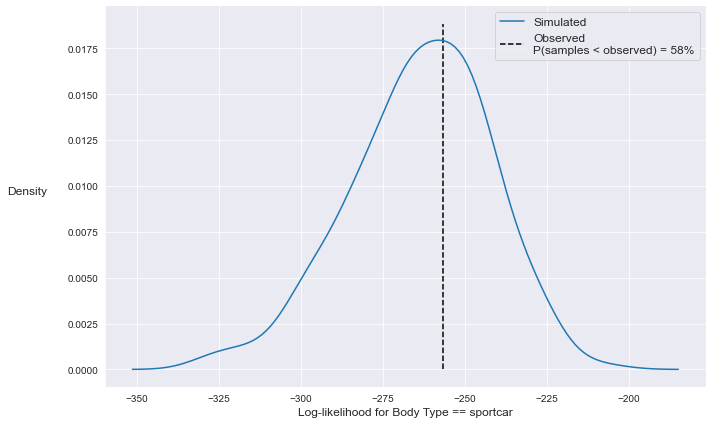

In [33]:
# Create the plot observed vs simulated log-likelihoods for each body type
for body in body_types:
    # Filter the observations being used for the plot
    filter_array = (car_df[BODY_COLUMN] == body).values
    filter_idx = np.where(filter_array)

    current_probs = estimated_probs.numpy()[filter_idx]
    current_choices = mnl_model.choices[filter_idx]
    current_sim_choices = sim_choices[filter_idx[0], :]
    
    # Compute the observed log-likelihood for filtered obs
    current_log_likelihood =\
        np.dot(current_choices, np.log(current_probs))
    
    # Compute the simulated log-likelihoods for the filtered obs
    current_sim_log_likelihoods =\
        viz.compute_predictive_log_likelihoods(
            current_sim_choices, current_probs)
    
    # Create the label for the current plot
    current_label_base = 'Log-likelihood for Body Type == {}'
    current_label = current_label_base.format(body)
    
    # Create the path to where this plot should be stored
    plot_file_suffix =\
        'log_likelihood_plot_body_is_{}.jpg'.format(body)
    current_plot_path =\
        pathlib.Path(FIGURE_DIR) / plot_file_suffix
    
    # Create the current plot
    viz.plot_continous_scalars(current_sim_log_likelihoods,
                               current_log_likelihood,
                               x_label=current_label,
                               output_file=current_plot_path,
                              )

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


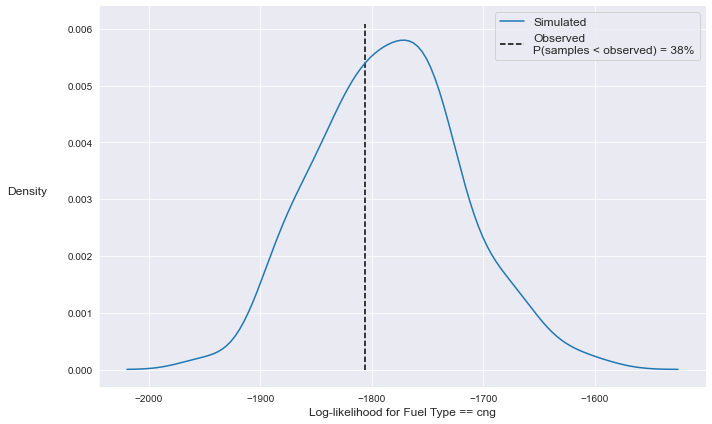

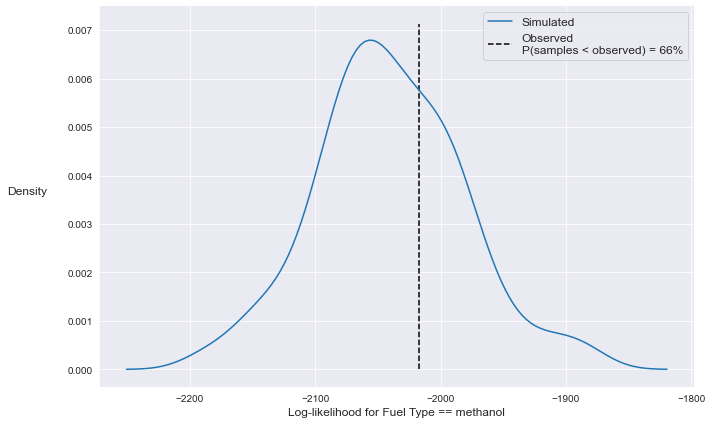

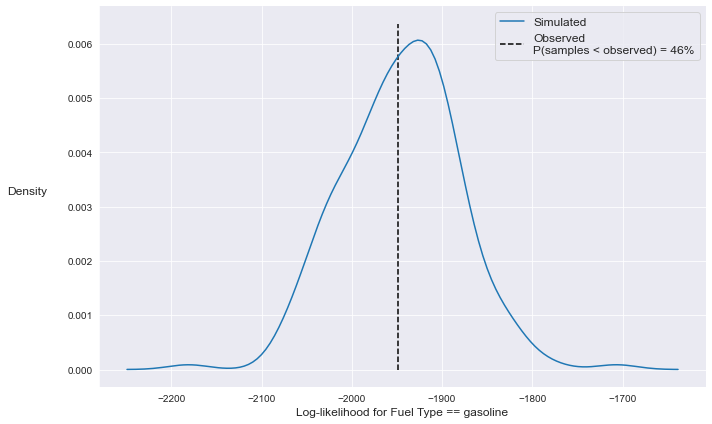

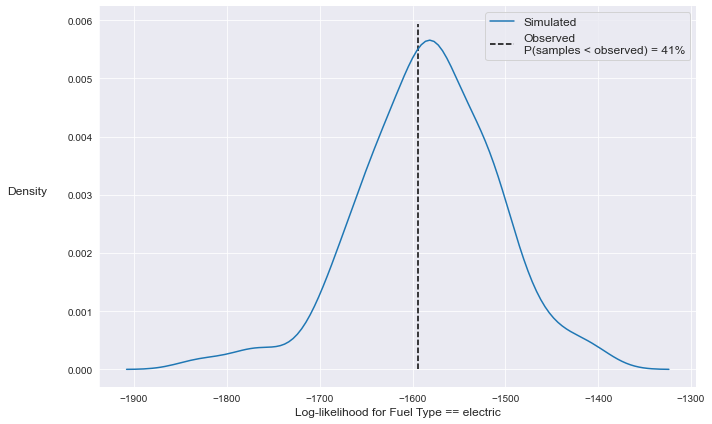

In [34]:
# Create the plot observed vs simulated log-likelihoods for each fuel type
for fuel in fuel_types:
    # Filter the observations being used for the plot
    filter_array = (car_df[FUEL_COLUMN] == fuel).values
    filter_idx = np.where(filter_array)

    current_probs = estimated_probs.numpy()[filter_idx]
    current_choices = mnl_model.choices[filter_idx]
    current_sim_choices = sim_choices[filter_idx[0], :]
    
    # Compute the observed log-likelihood for filtered obs
    current_log_likelihood =\
        np.dot(current_choices, np.log(current_probs))
    
    # Compute the simulated log-likelihoods for the filtered obs
    current_sim_log_likelihoods =\
        viz.compute_predictive_log_likelihoods(
            current_sim_choices, current_probs)
    
    # Create the label for the current plot
    current_label_base = 'Log-likelihood for Fuel Type == {}'
    current_label = current_label_base.format(fuel)
    
    # Create the path to where this plot should be stored
    plot_file_suffix =\
        'log_likelihood_plot_fuel_is_{}.jpg'.format(fuel)
    current_plot_path =\
        pathlib.Path(FIGURE_DIR) / plot_file_suffix
    
    # Create the current plot
    viz.plot_continous_scalars(current_sim_log_likelihoods,
                               current_log_likelihood,
                               x_label=current_label,
                               output_file=current_plot_path,
                              )

### 1d. Mean-square-error plots by body and fuel type

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using modul

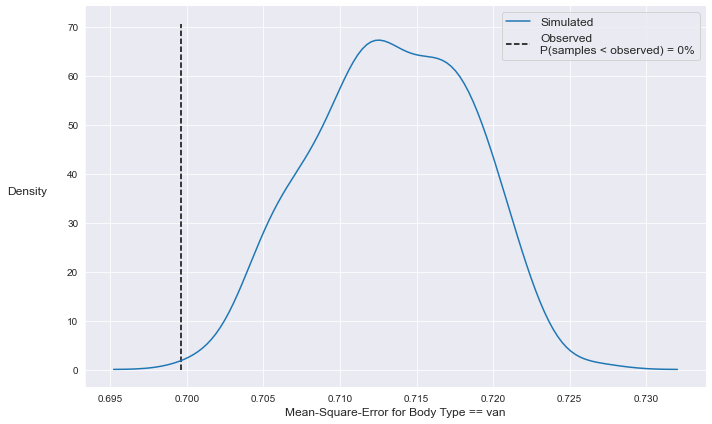

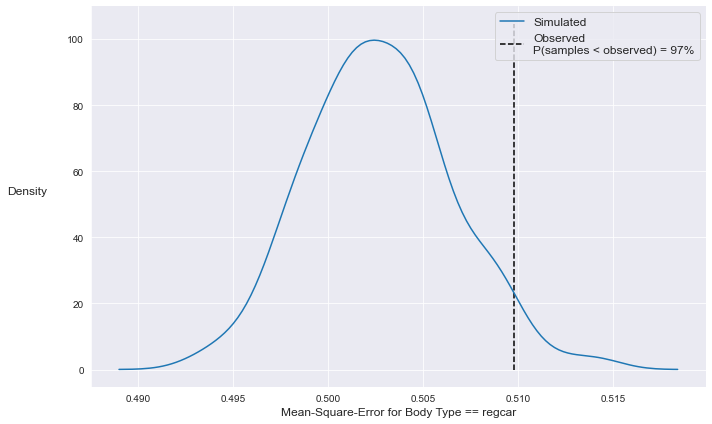

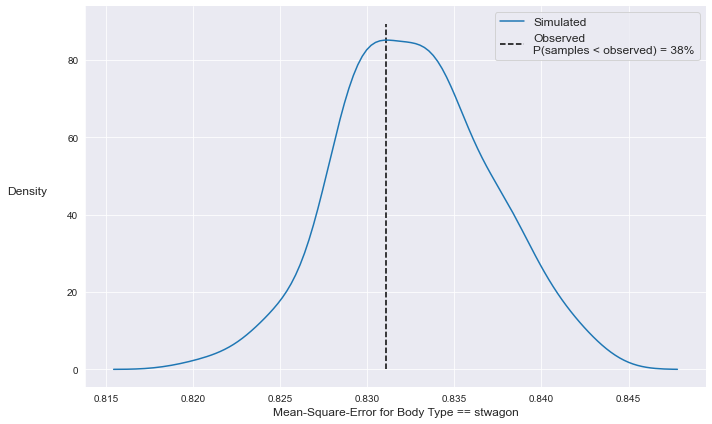

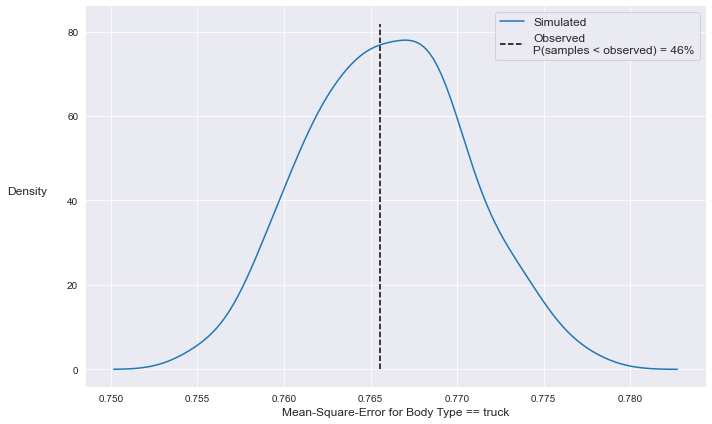

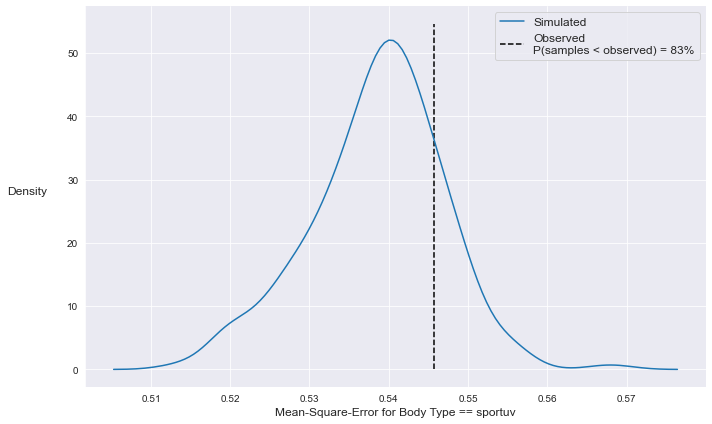

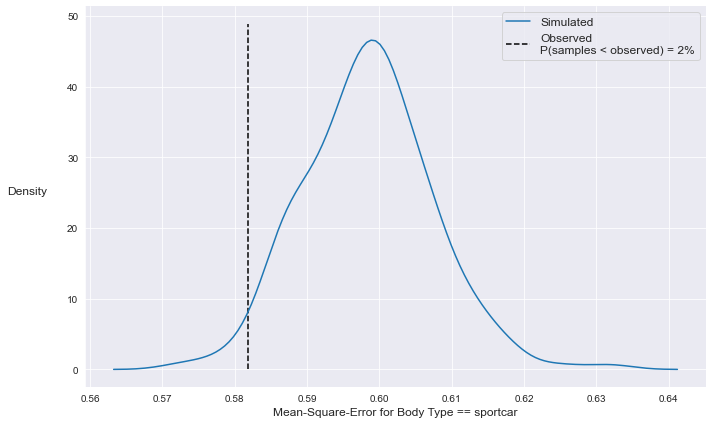

In [36]:
# Create the plot observed vs simulated mean-square-errors for each body type
for body in body_types:
    # Filter the observations being used for the plot
    filter_array = (car_df[BODY_COLUMN] == body).values
    filter_idx = np.where(filter_array)

    current_probs = estimated_probs.numpy()[filter_idx]
    current_choices = mnl_model.choices[filter_idx]
    current_sim_choices = sim_choices[filter_idx[0], :]
    
    # Compute the observed mean-square-error for filtered obs
    current_square_error = (current_choices - current_probs)**2
    current_mean_square_error =\
        current_square_error[np.where(current_choices)].mean()
    
    # Compute the simulated mean-square-errors for the filtered obs
    current_sim_mean_square_errors =\
        viz.compute_predictive_mse(
            current_sim_choices, current_probs)
    
    # Create the label for the current plot
    current_label_base = 'Mean-Square-Error for Body Type == {}'
    current_label = current_label_base.format(body)
    
    # Create the path to where this plot should be stored
    plot_file_suffix =\
        'mean_square_error_plot_body_is_{}.jpg'.format(body)
    current_plot_path =\
        pathlib.Path(FIGURE_DIR) / plot_file_suffix
    
    # Create the current plot
    viz.plot_continous_scalars(current_sim_mean_square_errors,
                               current_mean_square_error,
                               x_label=current_label,
                               output_file=current_plot_path,
                              )

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


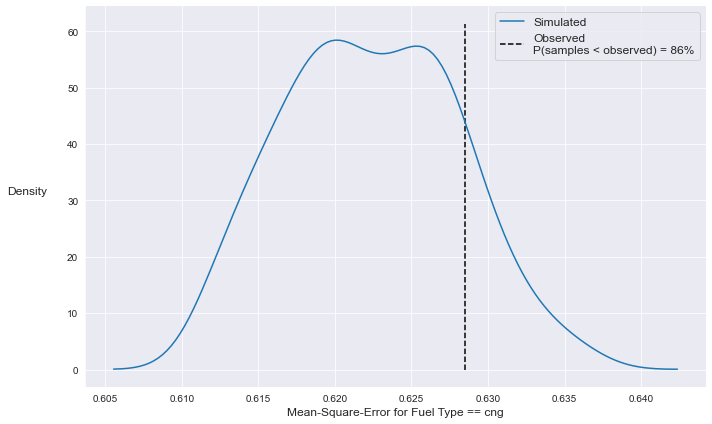

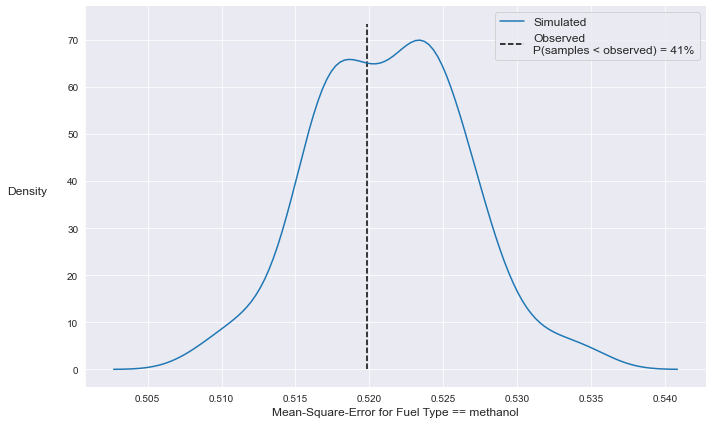

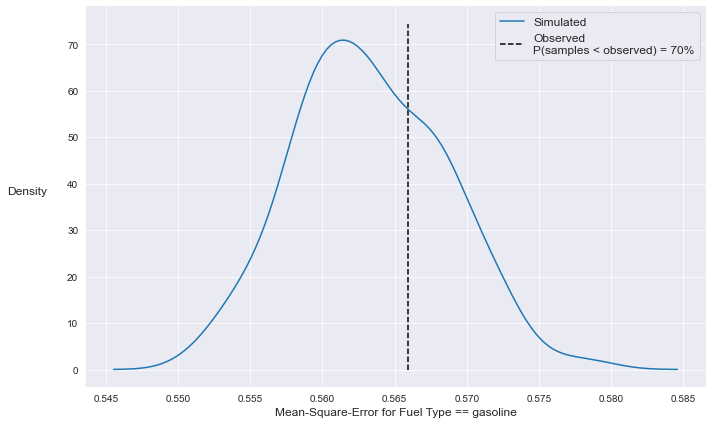

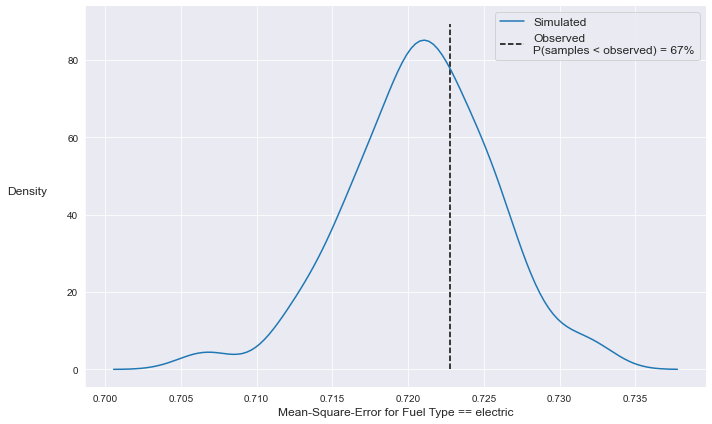

In [40]:
# Create the plot observed vs simulated mean-square-errors for each fuel type
for fuel in fuel_types:
    # Filter the observations being used for the plot
    filter_array = (car_df[FUEL_COLUMN] == fuel).values
    filter_idx = np.where(filter_array)

    current_probs = estimated_probs.numpy()[filter_idx]
    current_choices = mnl_model.choices[filter_idx]
    current_sim_choices = sim_choices[filter_idx[0], :]
    
    # Compute the observed mean-square-error for filtered obs
    current_square_error = (current_choices - current_probs)**2
    current_mean_square_error =\
        current_square_error[np.where(current_choices)].mean()
    
    # Compute the simulated mean-square-errors for the filtered obs
    current_sim_mean_square_errors =\
        viz.compute_predictive_mse(
            current_sim_choices, current_probs)
    
    # Create the label for the current plot
    current_label_base = 'Mean-Square-Error for Fuel Type == {}'
    current_label = current_label_base.format(fuel)
    
    # Create the path to where this plot should be stored
    plot_file_suffix =\
        'mean_square_error_plot_body_is_{}.jpg'.format(fuel)
    current_plot_path =\
        pathlib.Path(FIGURE_DIR) / plot_file_suffix
    
    # Create the current plot
    viz.plot_continous_scalars(current_sim_mean_square_errors,
                               current_mean_square_error,
                               x_label=current_label,
                               output_file=current_plot_path,
                              )

## 2. Market share plots

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


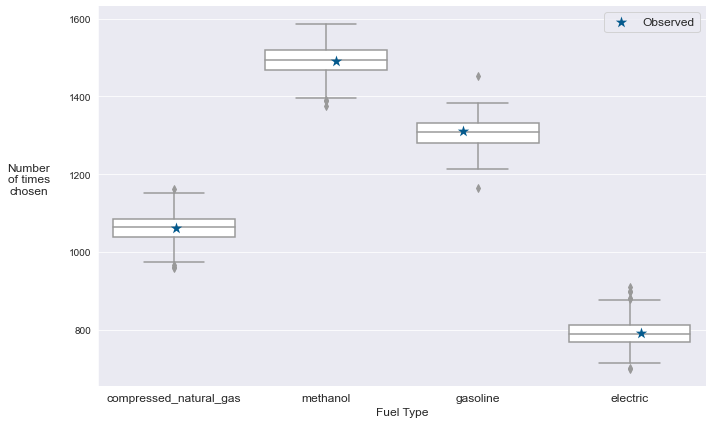

In [41]:
market_path = pathlib.Path(FIGURE_DIR) / 'market_share_plot_fuel_type.jpg'
market_dict = dict(cng='compressed_natural_gas')

viz.plot_simulated_market_shares(car_df.fuel_type.values,
                                 sim_choices,
                                 car_df.choice.values,
                                 x_label='Fuel Type',
                                 y_label='Number\nof times\nchosen',
                                 display_dict=market_dict,
                                 output_file=market_path)

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


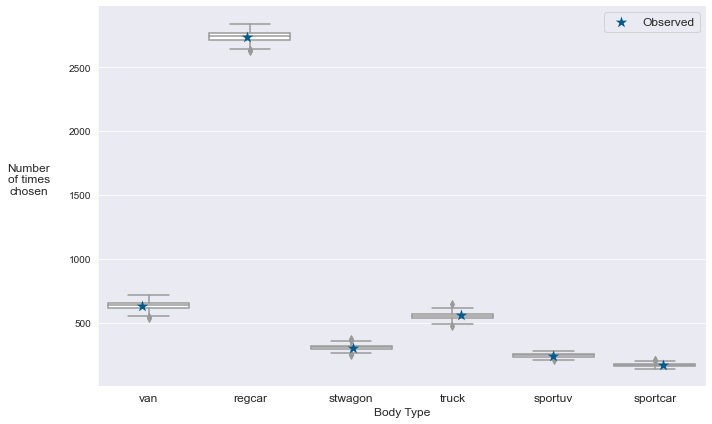

In [43]:
market_path_body = pathlib.Path(FIGURE_DIR) / 'market_share_plot_body_type.jpg'
viz.plot_simulated_market_shares(car_df.body_type.values,
                                 sim_choices,
                                 car_df.choice.values,
                                 x_label='Body Type',
                                 y_label='Number\nof times\nchosen',
                                 output_file=market_path_body)

## 3. Reliability plots

### 3a. Discretely-smoothed reliability plots

### 3b. Continuously-smoothed reliability plots

## 4. Marginal Model Plots

## 5. Simulated CDFs

## 6. Simulated KDEs

## 7. Simulated Histogram

# Conclusions